## Experimenting with AutoEncoders


Some experiments with using TensorFlows seq2seq APIs for Anomaly Detection in Multivariate Time Series

TODOS:
* GRU vs. LSTM

* Adjust number of hidden units?

* "There are certain similarities and differences between our model and the ones that [26] have used, which are worth mentioning. Our model is the same as theirs in that both of them accept sequential input data, produce encoded representation and then use it to make predictions. The difference, however, is in the way the encoded representation is used by the decoder. [26] handle it in two different ways. In the first one, they provide the encoded vector as input only to the first cell of the decoder LSTM, while the rest of the cells do not receive any input (unconditional model). In the other variant, the encoded vector is provided as input only to the first cell of the decoder LSTM, while for the remaining cells the output generated from the previous decoder cell is used as input (conditional model). They present arguments for and against both of these models, an important one being that conditioning the decoder cells on the previous cell’s output does not force it to look deep inside the encoder for valuable information. In our case, once we generate the encoded representation, we send this vector as input to each cell of the decoder. This ensures that the model only uses the actual inputs x1, . . . , xt to predict the outputs ˆxt+1,. . . , ˆxt+k. This is important because the errors in prediction do not accumulate. From the learning point of view, providing the encoded representation as input at each step of the decoder helps it learn by exploiting short-range correlations, rather than trying to use the encoded representation from k steps ago" [http://goelhardik.github.io/images/Multivariate_Aviation_Time_Series_Modeling_VARs_vs_LSTMs.pdf - Section 3.3]

## References:

* https://github.com/udacity/deep-learning/blob/master/seq2seq/sequence_to_sequence_implementation.ipynb 
* https://www.tensorflow.org/tutorials/seq2seq
* https://medium.com/google-cloud/how-to-do-time-series-prediction-using-rnns-and-tensorflow-and-cloud-ml-engine-2ad2eeb189e8 - to make an estimator
* https://github.com/tensorflow/tensorflow/issues/12065 - Seq2Seq without embeddings
* https://github.com/tensorflow/tensorflow/commit/e9a8d75bc470fb410fc54bf78fb4c9ff5d3bdff6 Inference Helper
* http://goelhardik.github.io/images/Multivariate_Aviation_Time_Series_Modeling_VARs_vs_LSTMs.pdf Multivariate Autoencoders (section 3.3)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# %load tfgraph_visualizer.py
"""
TensorFlow Graph visualizer code
Reference: https://blog.jakuba.net/2017/05/30/tensorflow-visualization.html
"""

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    """Visualize TensorFlow graph."""

    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()

    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))



### Sample Data Generators

In [3]:
feature_sin = lambda x: np.sin(x)
feature_cos = lambda x: np.cos(x)
feature_sin2 = lambda x: 2 * np.sin(x)
feature_sin_p2 = lambda x: np.sin(x) + 2
noise = lambda x, n: np.random.randn(len(x)) * n

### Configuration

In [4]:
class Seq2SeqConfig():
    """
    sequence_length - The number of time steps
    feature_funcs (list of lambdas) - The functions used to creature features
    """
    def __init__(self):
        self.sequence_length = 30
        self.hidden_units = 64
        self.batch_size = 10
        self.num_batches = 30
        self.num_epochs = 8
        
        self.feature_funcs = [feature_sin, feature_cos]
        self.num_features = len(self.feature_funcs)
        self.train_noise_factor = 0.15
        self.inference_noise_factor = 0.10
        
        self.feed_prev_decode_step = True
        self.learning_rate = 0.001 # 0.001 is the default learning rate used by the adam optimizer
        ## TODO - learning rate, drop out, number of units in the latent space

config = Seq2SeqConfig()


### A note on input shapes

Typically, the shape of the input follows two formats:
* Time Major:  `[num_timesteps x batch_size x num_features]`
* Batch Major: `[batch_size x num_timesteps x num_feature]`

####  Example of Time Major input

```
t=0  t=1    t=2  t=3     t=4
[The, brown, fox, is,     quick]
[The, red,   fox, jumped, high]

words_in_dataset[0] = [The, The]
words_in_dataset[1] = [brown, red]
words_in_dataset[2] = [fox, fox]
words_in_dataset[3] = [is, jumped]
words_in_dataset[4] = [quick, high]
batch_size = 2, time_steps = 5, num_features = 1

# Time Major:
tf.placeholder(tf.float32, [time_steps, batch_size, num_features])
```

#### Example of Batch Major input

```  
     feature_1 feature_2
t=0  50        0.5      
t=1  34        0.7     
t=2  60        0.2     
t=3  70        0.5     
t=4  80        0.9   
t=5  80        0.9   

batch[0] = [[50, 0.5], [34, 0.7], [60, 0.2]]
batch[1] = [[70, 0.5], [80, 0.9], [80, 0.9]]
batch_size = 2
time_steps = 3
num_features = 2

# Batch Major:
tf.placeholder(tf.float32, [batch_size, time_steps, num_features])
```

It seems to be easier and more intuitive to feed multivariate time series input as batch_major

Using `time_major = True` is a bit more efficient because it avoids transposes at the beginning and end of the RNN calculation. 

However, most TensorFlow data is batch-major, so by default tf.nn.dynamic_rnn accepts input and emits output in batch-major form.

Reference: https://www.tensorflow.org/versions/master/api_docs/python/tf/nn/dynamic_rnn

## Input Shape

The placeholders expect the input to be of the form:
```
batch[0] = [50, 0.5, 34, 0.7, 60, 0.2]
batch[1] = [70, 0.5, 80, 0.9, 80, 0.9]
```
Essentially

```
batch[0] = [f1_t0, f2_t0, f1_t1, f2_t1 ... f1_tn, f2_tn]
```
It will then be reshaped into batch major and transposed to time major

### Reset graph

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

### Placeholders

In [6]:
encoder_inputs = tf.placeholder(shape=(None, config.sequence_length * config.num_features), dtype=tf.float32, name='encoder_inputs')
decoder_inputs = tf.placeholder(shape=(None, config.sequence_length * config.num_features), dtype=tf.float32, name='decoder_inputs')

In [7]:
encoder_inputs_split = tf.reshape(encoder_inputs, [-1, config.sequence_length, config.num_features], name='encode_inputs_reshape')
decoder_inputs_split = tf.reshape(decoder_inputs, [-1, config.sequence_length, config.num_features], name='decode_inputs_reshape')

In [8]:
encoder_inputs_tm = tf.transpose(encoder_inputs_split, [1, 0, 2], name='encoder_inputs_batch_major_to_time_major')
decoder_inputs_tm = tf.transpose(decoder_inputs_split, [1, 0, 2], name='decoder_inputs_batch_major_to_time_major')

### Encoder

In [9]:
with tf.variable_scope('encoder'):
    encoder_cell = tf.contrib.rnn.LSTMCell(config.hidden_units)
    
    encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
        cell=encoder_cell,         
        inputs=encoder_inputs_tm,
        dtype=tf.float32,
        time_major=True)

In [10]:
encoder_outputs

<tf.Tensor 'encoder/rnn/TensorArrayStack/TensorArrayGatherV3:0' shape=(30, ?, 64) dtype=float32>

In [11]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'encoder/rnn/while/Exit_2:0' shape=(?, 64) dtype=float32>, h=<tf.Tensor 'encoder/rnn/while/Exit_3:0' shape=(?, 64) dtype=float32>)

### Training Decoder

In [12]:
with tf.variable_scope('decoder_cell'):
    decoder_cell = tf.contrib.rnn.LSTMCell(config.hidden_units)

In [13]:
with tf.variable_scope('projection_layer'):
    from tensorflow.python.layers.core import Dense
    projection_layer = Dense(config.num_features)

In [14]:
with tf.variable_scope('training_helper'):
    helper = tf.contrib.seq2seq.TrainingHelper(
    decoder_inputs_tm, 
    sequence_length=tf.constant(config.sequence_length, dtype=tf.int32, shape=[config.batch_size]),
    time_major=True)

In [15]:
with tf.variable_scope('training_decode_op'):
    decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell, helper, encoder_final_state, projection_layer)
    decoder_outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, output_time_major=True)

In [16]:
with tf.variable_scope('training_prediction'):
    prediction_op = tf.transpose(decoder_outputs.rnn_output, [1, 0, 2])

In [17]:
decoder_outputs.rnn_output

<tf.Tensor 'training_decode_op/decoder/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, 10, 2) dtype=float32>

### Loss Calculation

In [18]:
with tf.variable_scope("loss_calculation"):
    loss_op = tf.reduce_mean(tf.square(decoder_outputs.rnn_output - decoder_inputs_tm))
    train_op = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(loss_op, name='optimizer_minimize_loss') # the default learning rate for the adam optimizer is 0.001

In [19]:
# show_graph()

### Inference Decoder

###  Generate Data

In [20]:
def generate_batch(seq_len, batch_size, feature_funcs, noise_factor=0):
    
    # generate x values
    x = np.linspace(0, 30, 105)
    
    # pick random non-overlapping start points on the x
    total_start_points = len(x) - seq_len 
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    # get the x values for the sequence
    x_vals =  [x[i:(i + seq_len)] for i in start_x_idx]
    
    # get the y values for each signal
    y_vals = [None] * len(feature_funcs)
    for feature_id, func in enumerate(feature_funcs):
        y_vals[feature_id] = [func(x) + noise(x, noise_factor) for x in x_vals]
    
    # stack them together so a single batch looks like this:
    # [[f1_t0, f2_t0]
    #  [f1_t1, f2_t1]
    # ..
    #  [f1_tn, f2_tn]] 
    batch = np.stack(y_vals, -1)

    return batch

In [21]:
training_batches = [generate_batch(config.sequence_length, config.batch_size, config.feature_funcs, noise_factor=config.train_noise_factor) 
         for batch in range(config.num_batches)]

##  Training process

In [22]:
sess.run(tf.global_variables_initializer())

In [23]:
loss_tracker = [] 
pred_tracker = [None] * config.num_batches
err_tracker  = [None] * config.num_batches

for epoch in range(config.num_epochs):
    for batch_i, batch in enumerate(training_batches):
        batch_collapse = np.reshape(batch, (-1, config.num_features* config.sequence_length))
        _, loss, out = sess.run([train_op, loss_op, prediction_op], {encoder_inputs: batch_collapse, decoder_inputs: batch_collapse})
        loss_tracker.append(loss)
        
        # Just track the results of the last epoch
        # if epoch == config.num_batches:
        err_tracker[batch_i] = loss
        pred_tracker[batch_i] = out
        
        print('epoch: {}, batch: {}, loss: {}'.format(epoch, batch_i, loss))

epoch: 0, batch: 0, loss: 0.6091852784156799
epoch: 0, batch: 1, loss: 0.5883908271789551
epoch: 0, batch: 2, loss: 0.5483936667442322
epoch: 0, batch: 3, loss: 0.5208147764205933
epoch: 0, batch: 4, loss: 0.49848002195358276
epoch: 0, batch: 5, loss: 0.4877009987831116
epoch: 0, batch: 6, loss: 0.45741841197013855
epoch: 0, batch: 7, loss: 0.4268650412559509
epoch: 0, batch: 8, loss: 0.4050816595554352
epoch: 0, batch: 9, loss: 0.3852779269218445
epoch: 0, batch: 10, loss: 0.3620585501194
epoch: 0, batch: 11, loss: 0.3212455213069916
epoch: 0, batch: 12, loss: 0.32729172706604004
epoch: 0, batch: 13, loss: 0.30290162563323975
epoch: 0, batch: 14, loss: 0.26841142773628235
epoch: 0, batch: 15, loss: 0.2379308044910431
epoch: 0, batch: 16, loss: 0.23217043280601501
epoch: 0, batch: 17, loss: 0.20205549895763397
epoch: 0, batch: 18, loss: 0.18199265003204346
epoch: 0, batch: 19, loss: 0.15887533128261566
epoch: 0, batch: 20, loss: 0.14353808760643005
epoch: 0, batch: 21, loss: 0.11827603

epoch: 6, batch: 0, loss: 0.018651103600859642
epoch: 6, batch: 1, loss: 0.019374942407011986
epoch: 6, batch: 2, loss: 0.019987232983112335
epoch: 6, batch: 3, loss: 0.019116485491394997
epoch: 6, batch: 4, loss: 0.020481815561652184
epoch: 6, batch: 5, loss: 0.017643608152866364
epoch: 6, batch: 6, loss: 0.02072758786380291
epoch: 6, batch: 7, loss: 0.01712149567902088
epoch: 6, batch: 8, loss: 0.018308477476239204
epoch: 6, batch: 9, loss: 0.019239023327827454
epoch: 6, batch: 10, loss: 0.020642220973968506
epoch: 6, batch: 11, loss: 0.017349788919091225
epoch: 6, batch: 12, loss: 0.02053951472043991
epoch: 6, batch: 13, loss: 0.01770283468067646
epoch: 6, batch: 14, loss: 0.01762780360877514
epoch: 6, batch: 15, loss: 0.017955457791686058
epoch: 6, batch: 16, loss: 0.018745357170701027
epoch: 6, batch: 17, loss: 0.0205665435642004
epoch: 6, batch: 18, loss: 0.019251639023423195
epoch: 6, batch: 19, loss: 0.019635727629065514
epoch: 6, batch: 20, loss: 0.018330739811062813
epoch: 6,

### Graph the predictions vs actual

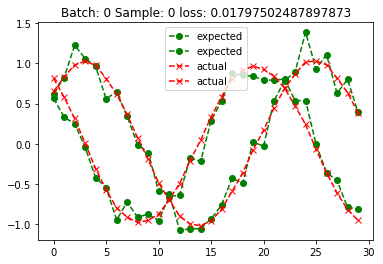

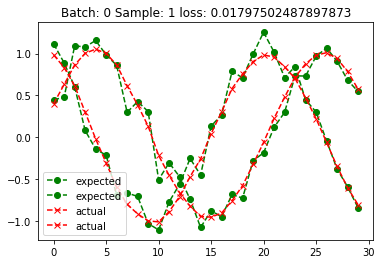

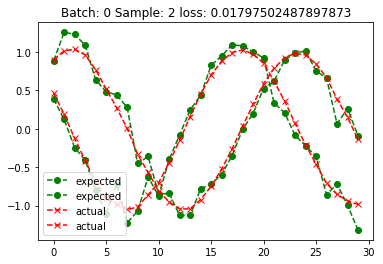

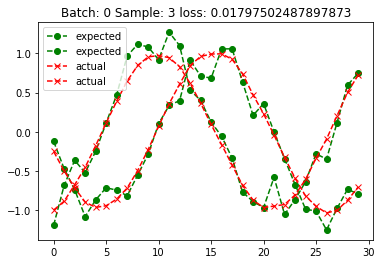

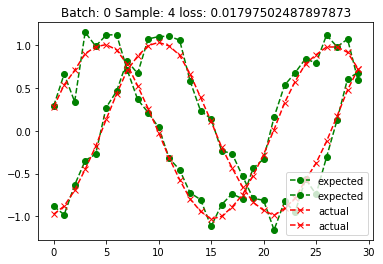

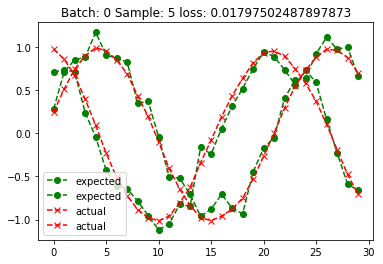

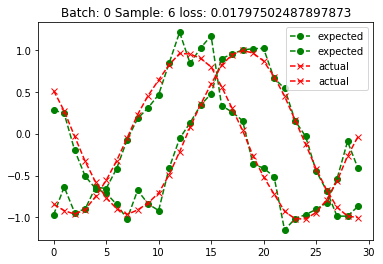

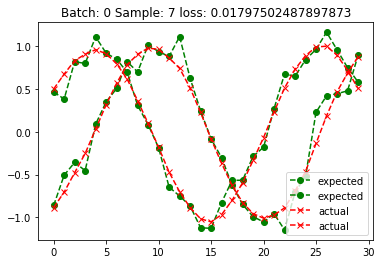

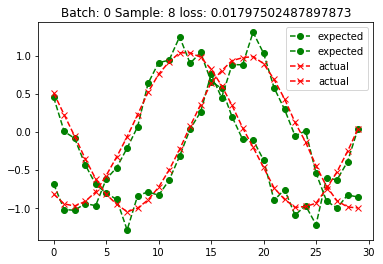

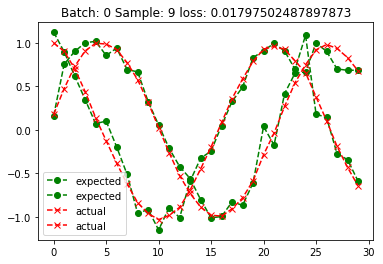

In [24]:
# pick a batch to graph
batch_id = 0
assert(batch_id < config.num_batches)
batch = training_batches[batch_id]

for sample in range(config.batch_size):
    plt.title('Batch: {} Sample: {} loss: {}'.format(batch_id, sample, err_tracker[batch_id]))
    plt.plot(training_batches[batch_id][sample], 'go--', label='expected')
    plt.plot(pred_tracker[batch_id][sample], 'rx--', label='actual')
    plt.legend(loc='best')
    plt.show()

## Graph the loss

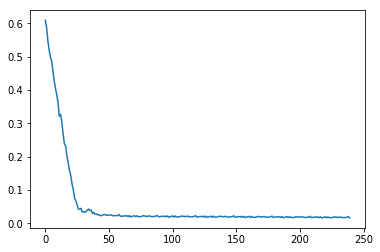

In [25]:
plt.plot(loss_tracker)
plt.show()

## Inference Decoder

In [26]:
encoder_outputs

<tf.Tensor 'encoder/rnn/TensorArrayStack/TensorArrayGatherV3:0' shape=(30, ?, 64) dtype=float32>

In [54]:
# Callables for the seq2seq.CustomHelper
# https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/CustomHelper
# TODO: So far, I've only been able to get this to work when what I presume is the batch_size is 1

def initialize_fn():
    # TODO: What should the start inputs be?
    # For most translation type problems, the first input appears to be a sentinel like <SOS>
    # Not sure how this is supposed to work for time series numerical data?
    # http://goelhardik.github.io/images/Multivariate_Aviation_Time_Series_Modeling_VARs_vs_LSTMs.pd - seems to indicate we need to pass in the encoded vector?
    
    finished = tf.tile([False], [1])
    start_inputs = tf.fill([1, config.num_features], 1.0)
    
    # What if we pass in the original signal?
    # encoder_output = encoder_inputs_tm[0, 0, :]
    # start_inputs = tf.reshape(encoder_output, shape=[1, config.num_features])
    
    return (finished, start_inputs)

def sample_fn(time, outputs, state):
    # TODO: Does this matter for our purposes?
    # The output is not an embedding as described here: https://www.tensorflow.org/tutorials/seq2seq#inference_how_to_generate_translations
    # So, we shouldn't need to implement an attention mechanism
    return tf.constant([0])

def next_input_fn(time, outputs, state, sample_ids):
    """
    Arguments:
        outputs - Tensor for shape (?, num_features)
        state - LSTMStateTuple(c shape=(?,hidden_units), h=(?,hidden_units))
    """
    # TODO: Two options here according to http://goelhardik.github.io/images/Multivariate_Aviation_Time_Series_Modeling_VARs_vs_LSTMs.pd
    # option 1: Send the output of the previous decoder step as input
    # option 2: Send the encoded vector as input to each cell of the decoder
    
    if config.feed_prev_decode_step:
        # Option 1
        # Grab the output. 
        # Our start_input is of shape (1, num_features). The shape of outputs is (?, num_features). 
        # If I feed the output as input directly, it fails the loop invariant check because of the shape difference
        # So, perform some gymnatics?
        output = outputs[0, :] # Note, 0 because all the callables implemented here are working against a batch size of 1
        next_input = tf.expand_dims(output, axis=0)
    else:
        # Option 2 
        pass
        # encoder_output = encoder_inputs_tm[time - 1, 0, :]
        # next_input = tf.layers.Dense(encoder_output, config.num_features).output
        # next_input = tf.reshape(encoder_output, shape=[1, config.num_features])
    
    # we have a predefined sequence length in our case
    finished = time >= config.sequence_length
    
    return (finished, next_input, state)

In [55]:
with tf.variable_scope('inference_helper'): 
    inference_helper = tf.contrib.seq2seq.CustomHelper(
        initialize_fn=initialize_fn,
        sample_fn=sample_fn,
        next_inputs_fn=next_input_fn,
    )

In [56]:
with tf.variable_scope('inference_decoder_op'): 
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell,
        inference_helper,
        encoder_final_state,
        projection_layer) 

In [57]:
inference_decoder_outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder, output_time_major=True)

In [58]:
with tf.variable_scope('inference_prediction'): 
    # transpose back to batch_major
    infer_prediction_op = tf.transpose(inference_decoder_outputs.rnn_output, [1, 0, 2])

In [59]:
#show_graph()

## Perform Inference

In [60]:
# generate with batch_size = 1
infer_batch = generate_batch(config.sequence_length, 1, config.feature_funcs, noise_factor=config.inference_noise_factor)

In [61]:
infer_batch.shape

(1, 30, 2)

In [62]:
infer_batch

array([[[  8.47196805e-01,   5.67635675e-01],
        [  9.21886345e-01,   4.49754036e-01],
        [  1.03620710e+00,   5.25901679e-02],
        [  8.66553820e-01,  -1.23735557e-01],
        [  8.26252536e-01,  -5.29715244e-01],
        [  7.63289871e-01,  -6.18414253e-01],
        [  4.71642895e-01,  -8.65133671e-01],
        [ -2.60187731e-04,  -8.93308618e-01],
        [ -1.91970949e-02,  -8.15677385e-01],
        [ -4.23290214e-01,  -7.80441094e-01],
        [ -6.28809844e-01,  -6.80388717e-01],
        [ -8.93629074e-01,  -6.52091133e-01],
        [ -9.57165927e-01,  -3.25846775e-01],
        [ -8.44612576e-01,   1.43683458e-01],
        [ -9.90994574e-01,   3.88399910e-01],
        [ -7.64003859e-01,   6.00365874e-01],
        [ -6.76975844e-01,   6.56273930e-01],
        [ -3.25085800e-01,   1.17009391e+00],
        [ -2.57128172e-01,   9.11472755e-01],
        [  1.43189335e-01,   8.97184324e-01],
        [  3.00009560e-01,   9.85265568e-01],
        [  7.83292272e-01,   7.027

In [63]:
infer_batch_collapse = np.reshape(infer_batch, (-1, config.num_features* config.sequence_length))

In [64]:
infer_batch_collapse.shape

(1, 60)

In [65]:
infer_out = sess.run([infer_prediction_op], {encoder_inputs: infer_batch_collapse, decoder_inputs: infer_batch_collapse})

In [66]:
infer_out[0]

array([[[ 0.83802837,  0.69461572],
        [ 0.98061073,  0.45653704],
        [ 1.06533659,  0.19445165],
        [ 1.08599019, -0.07613932],
        [ 1.03841066, -0.34029788],
        [ 0.92543221, -0.58429414],
        [ 0.75478613, -0.79539138],
        [ 0.53723097, -0.96147281],
        [ 0.2852186 , -1.07136691],
        [ 0.01279828, -1.1159575 ],
        [-0.26372576, -1.09033704],
        [-0.52608496, -0.99582189],
        [-0.75656974, -0.83960617],
        [-0.94100714, -0.63267046],
        [-1.06933701, -0.38848618],
        [-1.13445115, -0.1226423 ],
        [-1.13220227,  0.14801884],
        [-1.06314945,  0.40678388],
        [-0.93346143,  0.63839096],
        [-0.75317097,  0.83027959],
        [-0.53331035,  0.97319144],
        [-0.28440839,  1.0604862 ],
        [-0.0171072 ,  1.08731401],
        [ 0.2558147 ,  1.05119336],
        [ 0.51777053,  0.95342308],
        [ 0.7495721 ,  0.79928684],
        [ 0.93369329,  0.59691375],
        [ 1.05799532,  0.356

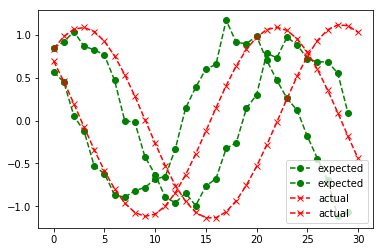

In [67]:
plt.plot(infer_batch[0], 'go--', label='expected')
plt.plot(infer_out[0][0], 'rx--', label='actual')
plt.legend(loc='best')
plt.show()

## Results

Not great. Even with a noise factor of 0 in training and inference, the predictions are close but not exact.
With such simple data, I would expect this to be perfect. 

I suspect the CustomHelper callables are incorrect